In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout,SimpleRNN,Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

importing  sales data

In [55]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
online_retail = fetch_ucirepo(id=352) 
  
# data (as pandas dataframes) 
X = online_retail.data.features 
y = online_retail.data.targets 
  
# metadata 
print(online_retail.metadata) 
  
# variable information 
print(online_retail.variables) 


{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [64]:
data = pd.DataFrame(X)

data[["Date", "Time"]] = data["InvoiceDate"].str.split(" ", expand=True)

data["Date"] = pd.to_datetime(data["Date"])

data = data[["Description", "Quantity", "Date"]]

data

,Description,Quantity,Date
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01
1,WHITE METAL LANTERN,6,2010-12-01
2,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01
4,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01
...,...,...,...
541904,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09
541905,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09
541906,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09
541907,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09


wheather data

In [70]:
data_wheather = pd.read_csv("data.csv")
data_wheather.columns = data_wheather.columns.str.strip() 

data_wheather = data_wheather[["DATE", "TEMP", "MAX", "MIN", "PRCP", "FRSHTT"]]
data_wheather.rename(columns={"DATE": "Date"}, inplace=True)
data_wheather.rename(columns={"PRCP": "Rain_amount"}, inplace=True)
data_wheather["FRSHTT"] = data_wheather["FRSHTT"].astype(str).str.zfill(6)
# spliting to individual 
data_wheather["Frost"] = data_wheather["FRSHTT"].str[0].astype(int)
data_wheather["Rain"] = data_wheather["FRSHTT"].str[1].astype(int)
data_wheather["Snow"] = data_wheather["FRSHTT"].str[2].astype(int)
data_wheather["Hail"] = data_wheather["FRSHTT"].str[3].astype(int)
data_wheather["Thunderstorm"] = data_wheather["FRSHTT"].str[4].astype(int)
data_wheather["Tornado"] = data_wheather["FRSHTT"].str[5].astype(int)
data_wheather = data_wheather.drop(columns=["FRSHTT"])
data_wheather["Date"] = pd.to_datetime(data_wheather["Date"])
data_wheather.head()


,Date,TEMP,MAX,MIN,Rain_amount,Frost,Rain,Snow,Hail,Thunderstorm,Tornado
0,2011-01-01,42.0,45.0,39.2,0.00,0,1,0,0,0,0
1,2011-01-02,37.3,39.2,35.6,0.02,1,0,0,0,0,0
2,2011-01-03,34.6,37.2,30.2,0.00,0,1,1,0,0,0
3,2011-01-04,36.9,41.0,32.5,0.00,0,1,0,0,0,0
4,2011-01-05,42.1,44.8,38.8,0.00,0,1,0,0,0,0


In [71]:
data_model = data[data["Description"] == "WHITE HANGING HEART T-LIGHT HOLDER"]
data_model.reset_index(drop=True, inplace=True)
data_model = data_model.groupby(["Description", "Date"], as_index=False)["Quantity"].sum()
data_model

,Description,Date,Quantity
0,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01,454
1,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-02,309
2,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-03,60
3,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-05,198
4,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-06,161
...,...,...,...
299,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-04,8
300,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-05,313
301,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-06,38
302,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-07,202


In [72]:
df_merged = pd.merge(data_model, data_wheather, on="Date", how="inner")
df_merged = df_merged.dropna()
df_merged

,Description,Date,Quantity,TEMP,MAX,MIN,Rain_amount,Frost,Rain,Snow,Hail,Thunderstorm,Tornado
0,WHITE HANGING HEART T-LIGHT HOLDER,2011-01-04,67,36.9,41.0,32.5,0.00,0,1,0,0,0,0
1,WHITE HANGING HEART T-LIGHT HOLDER,2011-01-05,303,42.1,44.8,38.8,0.00,0,1,0,0,0,0
2,WHITE HANGING HEART T-LIGHT HOLDER,2011-01-06,171,39.3,41.9,35.6,0.02,1,1,1,0,0,0
3,WHITE HANGING HEART T-LIGHT HOLDER,2011-01-07,333,43.0,51.4,33.8,0.45,1,1,0,0,0,0
4,WHITE HANGING HEART T-LIGHT HOLDER,2011-01-09,97,37.6,45.0,32.0,0.04,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-04,8,45.9,49.1,39.6,0.02,0,1,0,0,0,0
280,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-05,313,40.0,45.7,35.4,0.01,0,0,0,0,0,0
281,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-06,38,41.1,45.0,36.3,0.00,0,1,0,0,0,0
282,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-07,202,45.3,49.6,39.2,0.00,0,1,0,0,0,0


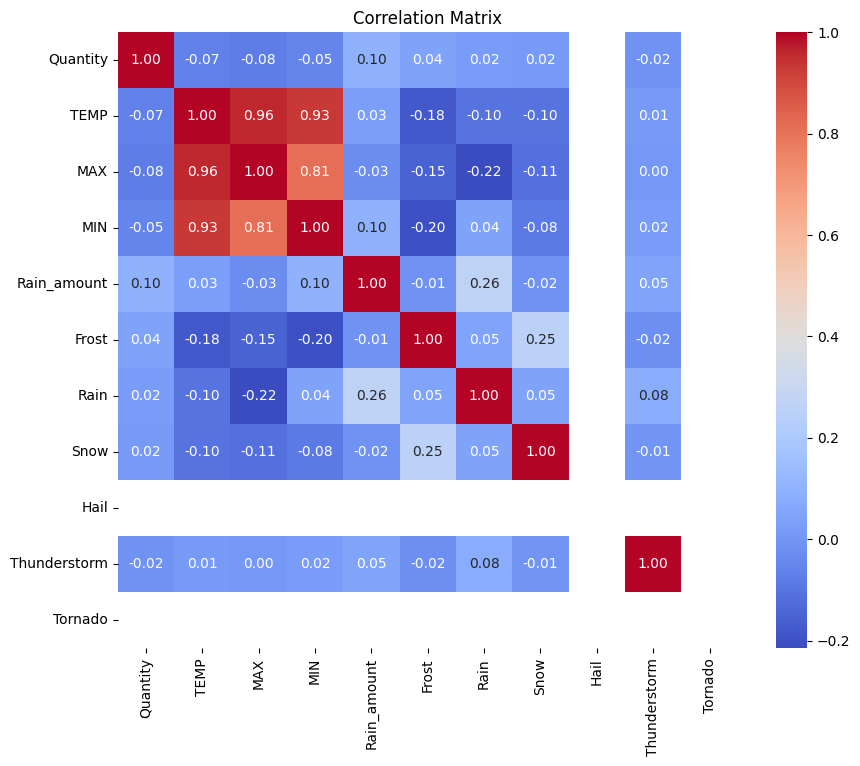

In [73]:

plt.figure(figsize=(10, 8))
sns.heatmap(df_merged.iloc[:,2:].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
